In [1]:
# Match CFHTLenS + VIPERS by STILTS
# java -jar stilts.jar tskymatch2 in1=CFHTLenS_W1.vot in2=VIPERS_W1_SPECTRO_PDR1.fits out=match_W1.fits ra1=ALPHA_J2000 dec1=DELTA_J2000 ra2=alpha dec2=delta error=1

In [2]:
# Code (General) Setup

def chi(z,omegam=0.27,H=100):
  # import cosmology
  # c0=cosmology.Cosmo(H0=H,omega_m=omegam)
  # return c0.Dc(0.,z)
  from astropy import cosmology
  from astropy.cosmology import FlatLambdaCDM
  cosmo = FlatLambdaCDM(H0=70, Om0=0.27)
  return cosmo.comoving_distance(z).value

def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)
    return hull.find_simplex(p)>=0

In [3]:
# Generate Random Catalog

import fitsio as fio
import numpy as np

import time
t0=time.time()

matched = fio.FITS('match_W1.fits')[-1].read()

data = matched[ (matched['fitclass']==0) & (matched['star_flag']==0) & (matched['weight']>0) ]
print '# of galaxies =',len(data)
datar=chi(data['zspec'])

import healpy as hp

p1=[ min(data['alpha'])-0.01 , min(data['delta'])-0.01 ]
p2=[ max(data['alpha'])+0.01 , max(data['delta'])+0.01 ]

ra=data['alpha']
dec=data['delta']
pix=hp.ang2pix(2**16, np.pi/2.-np.radians(dec),np.radians(ra), nest=False)

tmpphot=[]
with open('vipers_photo_pdr1_W1_edited.reg','r') as f:
  for line in f:
    tmpphot.append(np.fromstring(line, sep=' ').reshape(((1+line.count(' '))/2,2)))

pzpix=[]
for i in range(len(tmpphot)):
	pzpix=np.hstack( (pzpix, pix[in_hull(np.vstack((ra,dec)).T,tmpphot[i])]) )

mask2=np.in1d(pix,np.unique(pzpix),assume_unique=True)
mask=pix[~mask2]

data=data[~mask2]
print '# in VIPERS photo-z mask =',len(data)

# -------- randomize position --------------
rand_ra=p1[0]+np.random.random(100000000)*(p2[0]-p1[0])
rand_dec=p1[1]+np.random.random(100000000)*(p2[1]-p1[1])
randpix=hp.ang2pix(2**16, np.pi/2-np.radians(rand_dec), np.radians(rand_ra), nest=False)
mask3=np.in1d(randpix,mask,assume_unique=False)
rand_ra=rand_ra[mask3]
rand_dec=rand_dec[mask3]
print '# of rands = ',len(rand_ra)

# ---- ramdomly assign redshift ------------
rand_z=data['Z_B'][np.random.randint( 0 , len(data['Z_B'])-1 , len(rand_ra) )]
rand_r=chi(rand_z)

randfile = fio.FITS('rands.fits','rw')
randfile.write([rand_ra,rand_dec,rand_r],names=['ra','dec','r'])
randfile.close()

print '~~~~ Random catalog finished, time =',time.time()-t0

# of galaxies = 12459
# in VIPERS photo-z mask = 12389
# of rands =  94245
~~~~ Random catalog finished, time = 101.050657988


In [12]:
# Calculate Correlation Function

import time
t0=time.time()

import numpy as np

DPiL1=-300. # unit Mpc/h
DPiH1=0.
print '\Delta\Pi in [ ',DPiL1,', ',DPiH1,' )'
DPiL2=-60. # unit Mpc/h
DPiH2=60.
print '\Delta\Pi in [ ',DPiL2,', ',DPiH2,' )'
lb1='('+str(DPiL1)+', '+str(DPiH1)+')'
lb2='('+str(DPiL2)+', '+str(DPiH2)+')'

import fitsio as fio

randfile = fio.FITS('rands.fits')[-1].read()
rand_ra = randfile['ra']
rand_dec = randfile['dec']
rand_r = randfile['r']

import treecorr

dataE=treecorr.Catalog(g1=data['e1'], g2=data['e2']-data['c2'], w=data['weight'], ra=data['alpha'], dec=data['delta'], r=datar, ra_units='deg', dec_units='deg')
dataM=treecorr.Catalog(k=1+data['m'], w=data['weight'], ra=data['alpha'], dec=data['delta'], r=datar, ra_units='deg', dec_units='deg')
dataP=treecorr.Catalog(ra=data['alpha'], dec=data['delta'], w=data['weight'], r=datar, ra_units='deg', dec_units='deg')
randP=treecorr.Catalog(ra=rand_ra, dec=rand_dec, r=rand_r, ra_units='deg', dec_units='deg')

dataE1=treecorr.Catalog(g1=data['e1'], g2=data['e2']-data['c2'], w=data['weight'], ra=data['alpha'], dec=data['delta'], ra_units='deg', dec_units='deg')

ED1=treecorr.NGCorrelation(nbins=10, min_sep=.3/.7, max_sep=100./.7, bin_slop=0.01, verbose=0, min_rpar=DPiL1/.7, max_rpar=DPiH1/.7)
mD1=treecorr.NKCorrelation(nbins=10, min_sep=.3/.7, max_sep=100./.7, bin_slop=0.01, verbose=0, min_rpar=DPiL1/.7, max_rpar=DPiH1/.7)
ER1=treecorr.NGCorrelation(nbins=10, min_sep=.3/.7, max_sep=100./.7, bin_slop=0.01, verbose=0, min_rpar=-3000, max_rpar=3000)
mR1=treecorr.NKCorrelation(nbins=10, min_sep=.3/.7, max_sep=100./.7, bin_slop=0.01, verbose=0, min_rpar=-3000, max_rpar=3000)
RR1=treecorr.NNCorrelation(nbins=10, min_sep=.3/.7, max_sep=100./.7, bin_slop=0.01, verbose=0, min_rpar=-3000, max_rpar=3000)

ED1.process(dataP,dataE,metric='Rperp')
mD1.process(dataP,dataM,metric='Rperp')
ER1.process(randP,dataE,metric='Rperp')
mR1.process(randP,dataM,metric='Rperp')
RR1.process(randP,randP,metric='Rperp')

xi_gp1=ED1.xi/mD1.xi-ER1.xi/mR1.xi
#xi_gp=(ED.xi/mD.xi*ED.npairs-ER.xi/mR.xi*ER.npairs)/RR.npairs
wgp1=xi_gp1*(DPiH1-DPiL1)
error_wgp1=np.sqrt( (ED1.varxi/ED1.xi**2 + mD1.varxi/mD1.xi**2) * (ED1.xi/mD1.xi)**2 + (ER1.varxi/ER1.xi**2 + mR1.varxi/mR1.xi**2) * (ER1.xi/mR1.xi)**2 ) *(DPiH1-DPiL1)
#error_wgp=np.sqrt( ED.varxi*(ED.npairs/RR.npairs)**2 + ER.varxi*(ER.npairs/RR.npairs)**2 )*120
detection=np.sqrt( sum((wgp1/error_wgp1)**2) /9 )

xi_gx=ED1.xi_im/mD1.xi-ER1.xi_im/mR1.xi
wgx=xi_gx*(DPiH1-DPiL1)
error_wgx=np.sqrt( (ED1.varxi/ED1.xi_im**2 + mD1.varxi/mD1.xi**2) * (ED1.xi_im/mD1.xi)**2 + (ER1.varxi/ER1.xi_im**2 + mR1.varxi/mR1.xi**2) * (ER1.xi_im/mR1.xi)**2 ) *(DPiH1-DPiL1)

print 'wgp = ',wgp1
print 'error_wgp = ',error_wgp1
print 'mean r = ',ED1.meanr
print 'ED pairs N = ',ED1.npairs
print 'detection = ',detection
print '~~~~~~~~~~~~~~~~~~~~~~~~ process finished time = ',time.time()-t0

\Delta\Pi in [  -300.0 ,  0.0  )
\Delta\Pi in [  -60.0 ,  60.0  )
wgp =  [ 0.12290212 -0.35922255 -0.41165935 -0.17778486 -0.06812962 -0.0641922
  0.07556222 -0.03634022  0.13785886 -0.07170232]
error_wgp =  [ 0.35037618  0.20295396  0.12103106  0.0715424   0.04250229  0.02472774
  0.01559986  0.01127125  0.00945109  0.00789543]
mean r =  [   0.61347963    1.08873275    1.9506242     3.48260771    6.2400851
   11.14251216   19.74125121   34.60728467   61.6540402   110.06722307]
ED pairs N =  [  3.40700000e+03   1.02050000e+04   2.85720000e+04   8.19190000e+04
   2.31688000e+05   6.86607000e+05   1.72925000e+06   3.31646100e+06
   4.71383700e+06   6.75653800e+06]
detection =  6.31934134828
~~~~~~~~~~~~~~~~~~~~~~~~ process finished time =  58905.312032


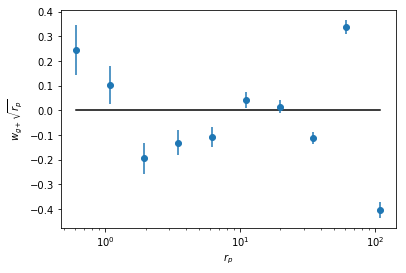

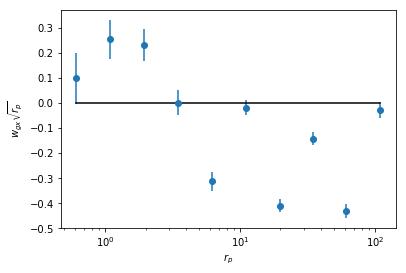

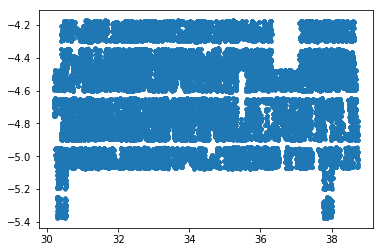

In [11]:
import matplotlib
# matplotlib.use('Agg')

from matplotlib import pyplot as plt

fig1=plt.figure()
plt.semilogx()
p1= plt.errorbar(ED1.meanr,wgp1*np.sqrt(ED1.meanr),error_wgp1*np.sqrt(ED1.meanr),fmt='o',label=lb1)
# p2= plt.errorbar(ED2.meanr*1.1,wgp2*np.sqrt(ED2.meanr),error_wgp2*np.sqrt(ED2.meanr),fmt='o',label=lb2)
plt.plot(ED1.meanr,np.zeros(10),color='k')
plt.xlabel('$r_p$')
plt.ylabel('$w_{g+}\sqrt{r_p}$')
# plt.savefig('pycorr_plus.png')
# plt.legend(handles=[p1,p2])

fig2=plt.figure()
plt.semilogx()
plt.errorbar(ED1.meanr,wgx*np.sqrt(ED1.meanr),error_wgx*np.sqrt(ED1.meanr),fmt='o')
plt.plot(ED1.meanr,np.zeros(10),color='k')
plt.xlabel('$r_p$')
plt.ylabel('$w_{gx}\sqrt{r_p}$')
# plt.savefig('pycorr_cross.png')

fig3=plt.figure()
plt.plot(rand_ra,rand_dec,'.')
# plt.savefig('rands.png')

fig4=plt.figure()
plt.plot(data['alpha'],data['delta'],'.')
# plt.savefig('data.png')

#fig5=plt.figure()
#for i in range(len(tmpphot)):
#	plt.plot( np.append(tmpphot[i].T[0],tmpphot[i].T[0][0]), np.append(tmpphot[i].T[1],tmpphot[i].T[1][0]),'-')
#plt.savefig('mask.pdf')

plt.show()
